# Computing Fuel, Time, Spatial, and weather integrals


In [1]:
import sys
# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
sys.path.append(root_path)

# Package to read yml files
import yaml
# Package to handle file paths
import os
# Package to deal with DataFrames
import pandas as pd
# Package to plot stuff
import matplotlib.pyplot as plt
# Package for numerical and array handling
import numpy as np
# Package to read and write to .sqlite files
import sqlite3
# Package to keep track of time
import datetime

# Function to clear output from jupyter notebook
from IPython.display import clear_output
# Package for compressing dataframes into file
from src.data import compressors
# Package for defining and fitting weather models
from src.models import weather
# Utilities package
from src.common import utils
# Package for interpolating and estimating weather
from src.analysis import weather_interpolator

def sigmoid(x, mu = 0, sig = 1):
    return 1/(1+np.exp(-(x - mu)/sig))

# Time Integral
def integrate_time(state_vectors):
    return state_vectors['time'].iloc[-1] - state_vectors['time'].iloc[0]

def integrate_fuel(state_vectors):
    return state_vectors['used_fuel'].iloc[-1]

# Wind Integral
def integrate_wind(state_vectors):
    speed_of_sound = 666.739
    return np.sum(state_vectors['sknt'])/(speed_of_sound*len(state_vectors))

# Air Density Integral
def integrate_air_density(state_vectors):
    sea_level_density = 1.204
    return np.sum(state_vectors['air_density'])/(sea_level_density*len(state_vectors))

def integrate_air_pressure(state_vectors):
    sea_level_pressure = 1013.25
    return np.sum(state_vectors['air_pressure'])/(sea_level_pressure*len(state_vectors))

def integrate_clouds(state_vectors):
    max_clouds = 1
    return np.sum(state_vectors['clouds'])/(max_clouds*len(state_vectors))

def integrate_severity(state_vectors):
    max_severity = 1
    return np.sum(state_vectors['severity'])/(max_severity*len(state_vectors))


def integrate_distance(state_vectors):
    d = 0
    for row_a, row_b in zip(state_vectors[:-1].itertuples(), state_vectors[1:].itertuples()):
        d += utils.haversine_distance(row_a.lat, row_a.lon, row_b.lat, row_b.lon)
    return d

# Path from this notebook to the root directory
root_path = os.path.normpath(root_path)
# Path from root to the desired config file
config_path_from_root = os.path.normpath('config/config.yml')
# Defining path from this notebook to config file
config_path = os.path.join(root_path, config_path_from_root)

# Loading config file
with open(config_path, 'r',  encoding='utf8') as file:
    config = yaml.safe_load(file)

# Defining "clear-output" function to feed into logger
def clear():
    clear_output(wait=True)

# Creates an instance of a logger class to log all that happens, optional (but encouraged).
logger = utils.Logger(config, clear_function=None)

In [4]:

files = ['../data/flight/' + f for f in os.listdir('../data/flight/') if f.endswith('.sqlite')]

for file in files:
    flights_database = file

    conn = sqlite3.connect(flights_database)

    cursor = conn.cursor()

    table_name = 'state_vector_weather'
    
    query = f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}';"
    
    # Execute the query
    cursor.execute(query)
    
    result = cursor.fetchone()
    
    if result:
        
        cursor.execute("DROP TABLE IF EXISTS flights_integrals;")

        new_columns = ['time', 'fuel', 'distance', 'wind', 'air_density', 'air_pressure', 'clouds', 'severity']

        # Create the new table
        create_table_query = f'''
            CREATE TABLE flights_integrals (
                flight_id TEXT PRIMARY KEY,
                {", ".join([f"{col} REAL" for col in new_columns])}
            );
        '''
        # Create the new table if it doesn't exist
        cursor.execute(create_table_query) 

        flight_ids, icao24s = pd.read_sql_query("SELECT flight_id, icao24 FROM flights", conn).values.T

        i = 0
        for flight_id, icao24 in zip(flight_ids, icao24s):
            clear_output(wait=True)
            print(f'{i}/{len(flight_ids)} | {flight_id}')
            state_vectors = pd.read_sql_query(f"""
                SELECT DISTINCT sv.*, svw.*, svf.*
                FROM state_vectors sv
                JOIN flights ON flights.flight_id = sv.flight_id
                LEFT JOIN state_vector_weather svw ON svw.vector_id = sv.vector_id
                LEFT JOIN state_vector_fuel svf ON svf.vector_id = sv.vector_id
                WHERE sv.flight_id = '{flight_id}';
                                               """,
                                               conn)
            state_vectors = state_vectors.iloc[:, ::-1]

            # Drop duplicated column names, keeping the first occurrence (which is actually the last in the original DataFrame)
            state_vectors = state_vectors.loc[:, ~state_vectors.columns.duplicated(keep='first')]

            # Reverse the column order back to original
            state_vectors = state_vectors.iloc[:, ::-1]

            integrals = {'flight_id': flight_id,
                        'time': integrate_time(state_vectors),
                        'fuel': integrate_fuel(state_vectors),
                        'distance': integrate_distance(state_vectors),
                        'wind': integrate_wind(state_vectors),
                        'air_density': integrate_air_density(state_vectors),
                        'air_pressure': integrate_air_pressure(state_vectors),
                        'clouds': integrate_clouds(state_vectors),
                        'severity': integrate_severity(state_vectors)}

            insert_data = tuple(integrals.values())
            # Creating query to insert new values
            insert_query = f'''
                INSERT INTO flights_integrals (flight_id, {', '.join(new_columns)})
                VALUES ({', '.join('?' * len(insert_data))})
                ON CONFLICT(flight_id) DO UPDATE SET
                {', '.join([f"{col} = excluded.{col}" for col in new_columns])};
            '''
            cursor.execute(insert_query, insert_data)

            conn.commit()

            i += 1
    conn.close()


966/967 | a11380_1690482460_1690501195_KLAX_KJFK


In [41]:
len(flight_ids)

967

In [18]:
import os
import sqlite3
import pandas as pd

files = ['../data/flight/' + f for f in os.listdir('../data/flight/') if f.endswith('.sqlite')]

for file in files:
    print('=========')
    print(file)
    conn = sqlite3.connect(file)
    cur = conn.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cur.fetchall()
    tables = [table[0] for table in tables]
    counts = {table:0 for table in tables}
    for table in tables:
        cur.execute(f"SELECT COUNT(*) FROM {table}")
        row_count = cur.fetchone()[0]
        print(f"{table}: {row_count}")
        counts[table] = row_count        
    
    strout = file
    if "state_vector_weather" in tables:
        strout += ' | Weather: Yes'
    else:
        strout += ' | Weather: No'
    if "state_vector_fuel" in tables:
        strout += ' | Fuel: Yes'
    else:
        strout += ' | Fuel: No'
    print(strout)
    
    conn.close()
    

../data/flight/KDEN_KSEA_2023-01-01_2023-01-31.sqlite
sqlite_sequence: 0
flights: 649
state_vectors: 2938155
state_vector_weather: 2938155
state_vector_fuel: 2938155
flights_integrals: 335
../data/flight/KLAX_KJFK_2023-01-01_2023-01-31.sqlite
state_vectors: 10616462
sqlite_sequence: 1
flights: 1163
state_vector_weather: 10300542
state_vector_fuel: 10300542
flights_integrals: 595
../data/flight/KSEA_KDEN_2023-07-01_2023-07-31.sqlite
flights: 814
state_vectors: 3160183
sqlite_sequence: 1
state_vector_weather: 0
state_vector_fuel: 3160183
flights_integrals: 416
../data/flight/KLAX_KSFO_2023-01-01_2023-01-31.sqlite
state_vectors: 2789573
sqlite_sequence: 1
flights: 1462
state_vector_weather: 2789573
state_vector_fuel: 2789573
flights_integrals: 754
../data/flight/KJFK_KLAX_2023-07-01_2023-07-31.sqlite
flights: 999
state_vectors: 22724633
sqlite_sequence: 1
state_vector_weather: 9748879
state_vector_fuel: 9748879
flights_integrals: 510
../data/flight/KSFO_KLAX_2023-07-01_2023-07-31.sqlite
f

In [95]:
file = "../data/flight/KSFO_KLAX_2023-01-01_2023-01-31.sqlite"
conn = sqlite3.connect(file)

fuels = pd.read_sql_query(f"""
    SELECT fi.*, fs.icao24
    FROM flights_integrals AS fi
    JOIN flights as fs ON fs.flight_id = fi.flight_id
    ;""",conn)
fuels = fuels.dropna().sort_values('fuel')
flight_id = fuels.iloc[0]['flight_id']

state_vectors = pd.read_sql_query(f"""
    SELECT DISTINCT sv.*, svw.*, svf.*, fi.*
    FROM state_vectors sv
    JOIN state_vector_weather svw ON svw.vector_id = sv.vector_id
    LEFT JOIN state_vector_fuel svf ON svf.vector_id = sv.vector_id
    LEFT JOIN flights as fi ON sv.flight_id = fi.flight_id
    WHERE sv.flight_id = '{flight_id}';"""
                                  ,conn)
conn.close()

fuels


,flight_id,time,fuel,distance,wind,air_density,air_pressure,clouds,severity,icao24
742,a4c492_1674164414_1674167368_KSFO_KLAX,b'\x85\x0b\x00\x00\x00\x00\x00\x00',825.278106,603710.014072,0.193041,0.545130,0.477546,0.320933,0.000000,a4c492
741,a4c492_1674164414_1674167368_KSFO_KLAX,b'\x85\x0b\x00\x00\x00\x00\x00\x00',825.278106,603710.014072,0.193041,0.545130,0.477546,0.320933,0.000000,a4c492
192,a4c492_1673113382_1673116648_KSFO_KLAX,b'\xbf\x0c\x00\x00\x00\x00\x00\x00',895.990035,582811.877796,0.193206,0.528478,0.464058,0.127187,0.000000,a4c492
191,a4c492_1673113382_1673116648_KSFO_KLAX,b'\xbf\x0c\x00\x00\x00\x00\x00\x00',895.990035,582811.877796,0.193206,0.528478,0.464058,0.127187,0.000000,a4c492
555,a4c492_1673825246_1673828409_KSFO_KLAX,b'Y\x0c\x00\x00\x00\x00\x00\x00',897.102168,623844.704572,0.170103,0.585780,0.515369,0.706171,0.000000,a4c492
...,...,...,...,...,...,...,...,...,...,...
570,a1e2c4_1673852358_1673855155_KSFO_KLAX,b'\xec\n\x00\x00\x00\x00\x00\x00',6387.363512,553898.816147,0.183027,0.578440,0.506112,0.756452,0.049428,a1e2c4
252,aac136_1673245291_1673248248_KSFO_KLAX,b'\x8c\x0b\x00\x00\x00\x00\x00\x00',6767.328828,593629.586828,0.192165,0.553639,0.492329,0.709019,0.000000,aac136
251,aac136_1673245291_1673248248_KSFO_KLAX,b'\x8c\x0b\x00\x00\x00\x00\x00\x00',6767.328828,593629.586828,0.192165,0.553639,0.492329,0.709019,0.000000,aac136
282,89647d_1673305655_1673309034_KSFO_KLAX,b'0\r\x00\x00\x00\x00\x00\x00',11796.652106,604083.807362,0.162973,0.598591,0.531283,0.692065,0.107636,89647d


In [103]:
from traffic.core import Flight
typecodes = []
for icao24 in fuels['icao24']:
    df = pd.DataFrame({'icao24':[icao24], 'timestamp':[0]})
    typecodes += [Flight(df).aircraft['typecode']]


In [108]:
fuels['typecode'] = typecodes

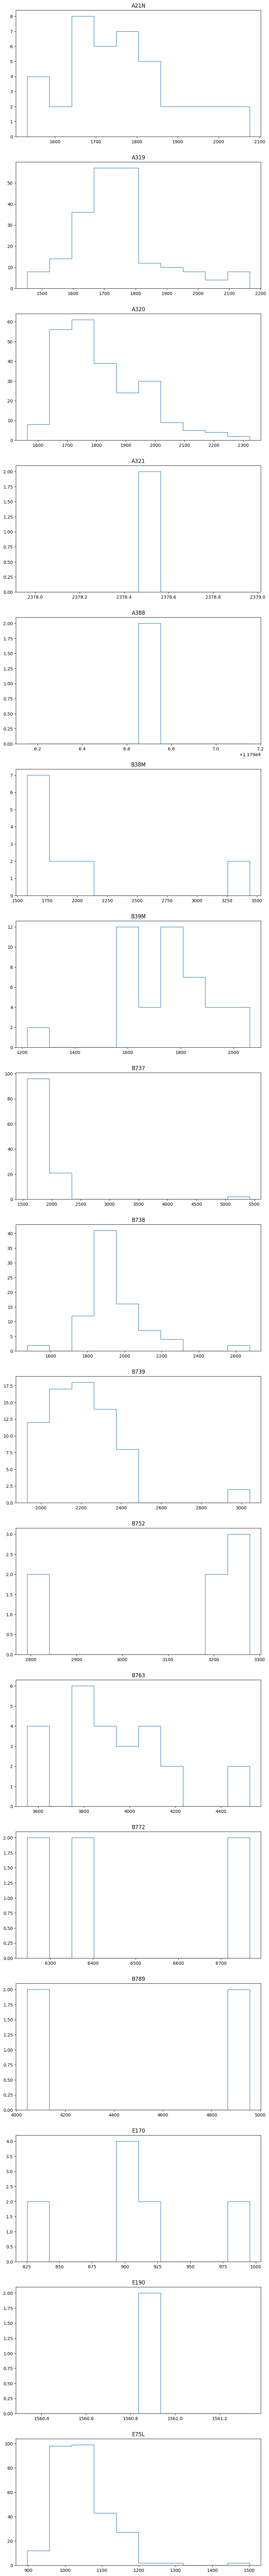

In [116]:
fig, ax = plt.subplots(len(np.unique(typecodes)), figsize = [10, len(np.unique(typecodes))*10/1.62])
for i, aicraft_type in enumerate(np.unique(typecodes)):
    ax[i].set_title(aicraft_type)
    ax[i].hist(fuels[fuels['typecode'] == aicraft_type]['fuel'], bins = 10, histtype = 'step', label = aicraft_type)

In [75]:
# We can get optimal flight path
# We need the weather calculation for the optimal path for the time of each of the other flights -> state_vector_weather_optimal
# Integrals for optimal -> flights_integrals_optimal
# flight time Vs weather
# distance Vs flight_time
# Plane Type

,vector_id,flight_id,time,time_normalized,lat,lon,geoaltitude,baroaltitude,heading,velocity,...,tmpf,air_pressure,air_density,clouds,sknt,severity,vector_id,mass,fuelflow,used_fuel
0,1449016,a4c492_1674164414_1674167368_KSFO_KLAX,1674164417,0,37.616913,-122.377001,-22.860000,-83.820000,27.699473,69.723770,...,53.332629,1016.034722,1.241949,0.06000,1.442800,0.0,1449016,30780.000000,0.634715,0.000000
1,1449017,a4c492_1674164414_1674167368_KSFO_KLAX,1674164418,1,37.617564,-122.376564,-17.821343,-78.781343,27.799105,70.962631,...,53.185727,1014.678312,1.240551,0.06007,1.700330,0.0,1449017,30779.365285,0.853600,0.634715
2,1449018,a4c492_1674164414_1674167368_KSFO_KLAX,1674164419,2,37.618216,-122.376128,-12.782686,-73.742686,27.898738,72.201491,...,53.038826,1013.321902,1.239152,0.06014,1.957859,0.0,1449018,30778.511685,0.822861,1.488315
3,1449019,a4c492_1674164414_1674167368_KSFO_KLAX,1674164420,3,37.618863,-122.375694,-7.631919,-68.591919,27.990665,73.388770,...,52.891925,1011.965492,1.237754,0.06021,2.215389,0.0,1449019,30777.688823,0.800689,2.311177
4,1449020,a4c492_1674164414_1674167368_KSFO_KLAX,1674164421,4,37.619427,-122.375322,-0.259975,-61.219975,27.929929,73.554094,...,52.745023,1010.609082,1.236356,0.06028,2.472919,0.0,1449020,30776.888134,0.905933,3.111866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,1451961,a4c492_1674164414_1674167368_KSFO_KLAX,1674167362,2945,33.954556,-118.378216,135.872308,124.625371,263.263063,61.399495,...,56.028491,980.844905,1.192668,0.50000,12.868106,0.0,1451961,29957.620523,0.665238,822.379477
2946,1451962,a4c492_1674164414_1674167368_KSFO_KLAX,1674167363,2946,33.954477,-118.379021,135.195965,122.044028,263.302774,61.757704,...,56.028491,980.844905,1.192668,0.50000,12.868106,0.0,1451962,29956.955285,0.655599,823.044715
2947,1451963,a4c492_1674164414_1674167368_KSFO_KLAX,1674167364,2947,33.954423,-118.379594,133.350000,121.920000,263.317869,61.896515,...,56.028491,980.844905,1.192668,0.50000,12.868106,0.0,1451963,29956.299686,0.787350,823.700314
2948,1451964,a4c492_1674164414_1674167368_KSFO_KLAX,1674167365,2948,33.954371,-118.380156,131.445000,121.920000,263.331722,62.024252,...,56.028491,980.844905,1.192668,0.50000,12.868106,0.0,1451964,29955.512335,0.790442,824.487665


In [ ]:
for file in files